In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from notebooks.utils import display, sample_batch

2024-07-04 15:59:59.064441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 15:59:59.244605: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 15:59:59.282585: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Prepare the data <a name="prepare"></a>

In [2]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [4]:
train_data = utils.image_dataset_from_directory(
    "/app/data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.


2024-07-04 16:04:37.159824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:5a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-04 16:04:37.188804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:5a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-04 16:04:37.189382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:5a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-04 16:04:37.196861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

In [7]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [8]:
train_sample = sample_batch(train)

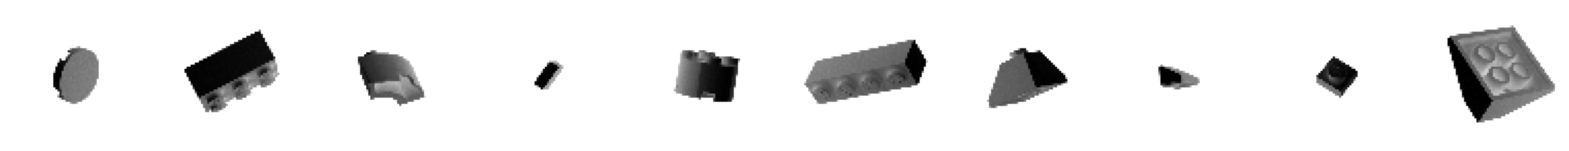

In [9]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [10]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                           

In [11]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_6 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [12]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generatorake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [13]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [ ]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [14]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [15]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            #save_to="./output/generated_img_%03d.png" % (epoch),
        )

Epoch 80/85
313/313 [==============================] - ETA: 0s - d_loss: -0.7645 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00

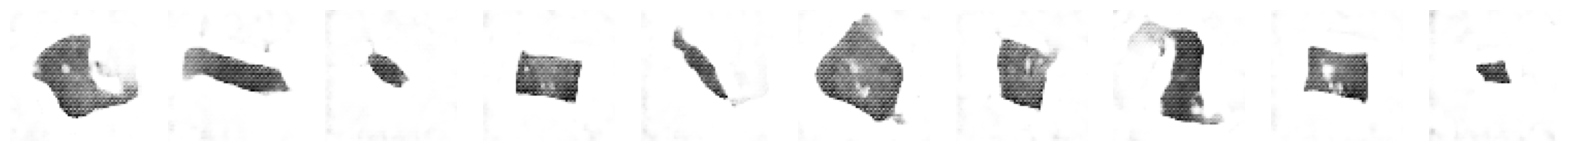

313/313 [==============================] - 92s 290ms/step - d_loss: -0.7645 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 81/85
313/313 [==============================] - ETA: 0s - d_loss: -0.7654 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00

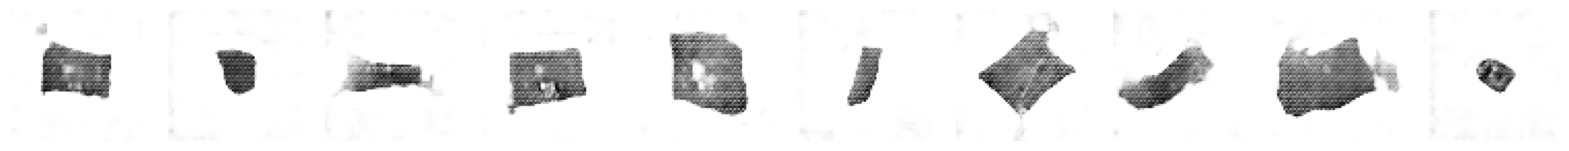

313/313 [==============================] - 93s 294ms/step - d_loss: -0.7654 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 82/85
313/313 [==============================] - ETA: 0s - d_loss: -0.7674 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00

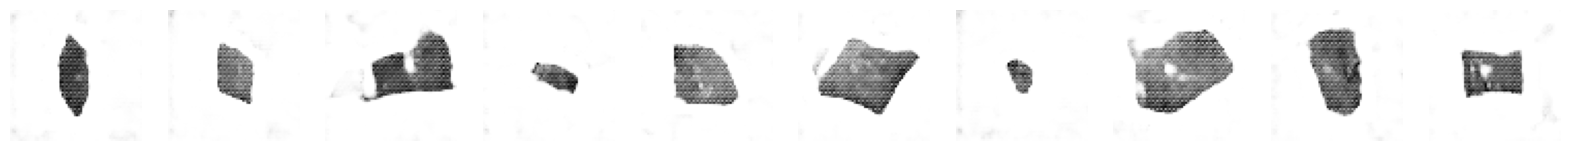

313/313 [==============================] - 94s 296ms/step - d_loss: -0.7674 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 83/85
313/313 [==============================] - ETA: 0s - d_loss: -0.7672 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00

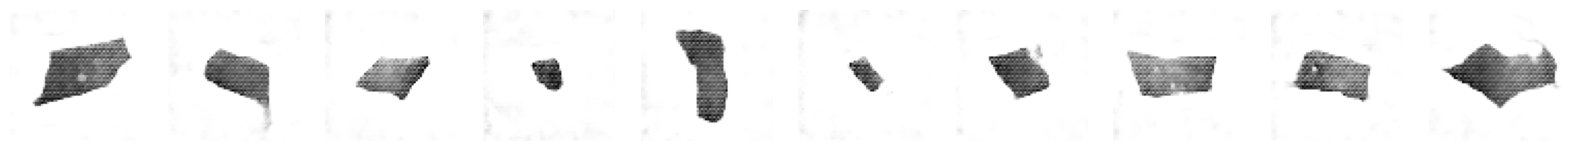

313/313 [==============================] - 94s 294ms/step - d_loss: -0.7672 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 84/85
313/313 [==============================] - ETA: 0s - d_loss: -0.7644 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00

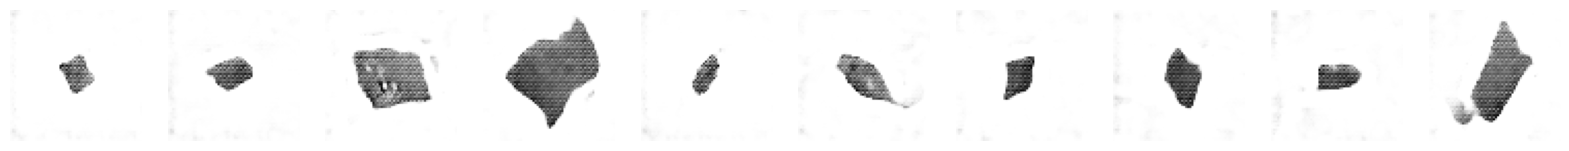

313/313 [==============================] - 93s 295ms/step - d_loss: -0.7644 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 85/85
313/313 [==============================] - ETA: 0s - d_loss: -0.7660 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00

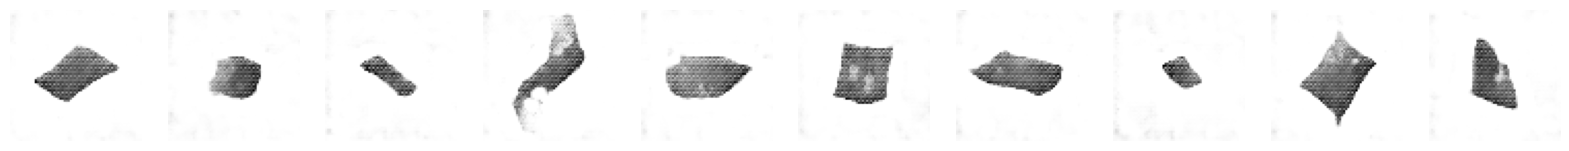

313/313 [==============================] - 93s 294ms/step - d_loss: -0.7660 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00


In [17]:
dcgan.fit(
    train,
    epochs=85,
    initial_epoch=79,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

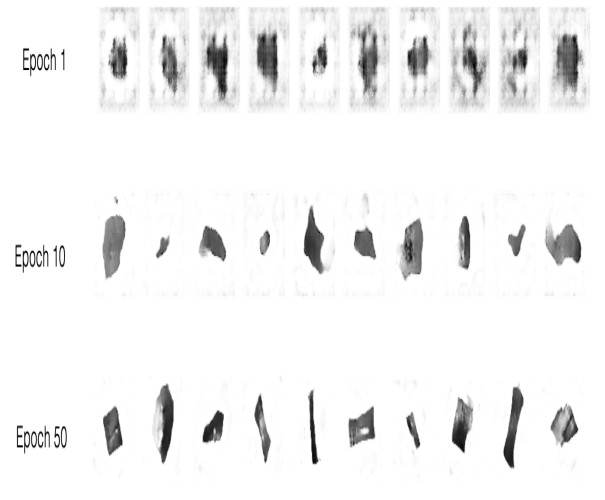

In [18]:
from IPython.display import Image
Image("progress.png")

In [19]:
# Save the final models
generator.save("./models/gan/generator")
discriminator.save("./models/gan/discriminator")

INFO:tensorflow:Assets written to: ./models/gan/generator/assets


INFO:tensorflow:Assets written to: ./models/gan/generator/assets


INFO:tensorflow:Assets written to: ./models/gan/discriminator/assets


INFO:tensorflow:Assets written to: ./models/gan/discriminator/assets


If discriminator loss function collapsing, several ways to weaken the discriminator:

Increase the rate parameter of the Dropout layers in the discriminator to dampen the amount of information that flows through the network

Reduce the learning rate of the discriminator

Reduce the number of convolutional filters in the discriminator

Add noise to the labels when training the discriminator

Flip the label of some images at random when training the discriminator

Since the deep learning model is compiled to minimize the loss function, it
would be natural to think that the smaller the loss function of the generator,
the better the quality of the images produced. However, since the generator
is only graded against the current discriminator and the discriminator is
constantly improving, we cannot compare the loss function evaluated at
different points in the training process.